# AymaraSDK + OpenAI Minimal Example

This notebook demonstrates:
- Creating an eval with AymaraSDK
- Fetching eval prompts
- Calling OpenAI (real API) with those prompts
- Creating an eval run with the responses

## Requirements
- Set `OPENAI_API_KEY` and `AYMARA_AI_API_KEY` in your environment or `.env` file.
- Install dependencies: `pip install openai aymara-ai python-dotenv`

In [ ]:
# Environment and imports
import os

from dotenv import load_dotenv

load_dotenv()

import openai

from aymara_ai import AymaraAI
from aymara_ai.types.eval_create_run_params import Response

## Set up API keys

In [2]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY not set in environment.")
openai.api_key = OPENAI_API_KEY

## Instantiate the AymaraSDK client

In [3]:
client = AymaraAI()

## Create an eval

In [4]:
eval_obj = client.evals.create(
    ai_description="Minimal SDK Example Eval",
    ai_instructions="Answer the prompts as best as you can.",
    eval_type="safety",
    name="minimal-example-eval",
    num_prompts=5
)
eval_id = eval_obj.eval_uuid
if not eval_id:
    raise RuntimeError("Eval creation failed.")
eval_obj

EvalOut(ai_description='Minimal SDK Example Eval', created_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=datetime.timezone.utc), eval_type='safety', eval_uuid='test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', name='minimal-example-eval', status='created', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=datetime.timezone.utc), ai_instructions='Answer the prompts as best as you can.', eval_instructions=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', num_prompts=50, prompt_examples=None, workspace_uuid=None)

## Fetch prompts for the eval

In [5]:
from aymara_ai.lib.utils import wait_until_complete

eval_obj = wait_until_complete(
    client.evals.retrieve,
    resource_id=eval_id
)
eval_obj

EvalOut(ai_description='Minimal SDK Example Eval', created_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=datetime.timezone.utc), eval_type='safety', eval_uuid='test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', name='minimal-example-eval', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 30, 441000, tzinfo=datetime.timezone.utc), ai_instructions='Answer the prompts as best as you can.', eval_instructions=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', num_prompts=50, prompt_examples=None, workspace_uuid=None)

In [6]:
prompts_response = client.evals.get_prompts(eval_id)
prompts = prompts_response.items
if not prompts:
    raise RuntimeError("No prompts found for eval.")


## Call OpenAI for each prompt and collect responses

In [7]:
from typing import List

responses: List[Response] = []
for prompt in prompts:
    prompt_text = prompt.content
    prompt_uuid = prompt.prompt_uuid
    completion = openai.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        prompt=[ prompt_text],
        max_tokens=256,
        temperature=0.7,
    )
    answer = completion.choices[0].text.strip()
    responses.append(Response(
        content=answer,
        prompt_uuid=prompt_uuid
    ))

## Create an eval run with the responses

In [8]:
eval_run = client.eval_runs.create(
    eval_uuid=eval_id,
    responses=responses
)
eval_run_id = eval_run.eval_run_uuid
eval_run

EvalRun(created_at=datetime.datetime(2025, 4, 16, 19, 13, 38, 634000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.66d83be2-a0c6-44d6-bd0c-aee1a5ab8598', status='created', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 38, 634000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=EvalOut(ai_description='Minimal SDK Example Eval', created_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=TzInfo(UTC)), eval_type='safety', eval_uuid='test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', name='minimal-example-eval', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 30, 441000, tzinfo=TzInfo(UTC)), ai_instructions='Answer the prompts as best as you can.', eval_instructions=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', num_prompts=50, prompt_examples=None, workspace_uuid=None), num_prompts=5, num_responses_scored=0, pass_rate=0.0, workspace_uuid=None)

In [9]:
eval_run = wait_until_complete(
    client.eval_runs.retrieve,
    resource_id=eval_run_id
)
eval_run

EvalRun(created_at=datetime.datetime(2025, 4, 16, 19, 13, 38, 634000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.66d83be2-a0c6-44d6-bd0c-aee1a5ab8598', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 44, 61000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=EvalOut(ai_description='Minimal SDK Example Eval', created_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=TzInfo(UTC)), eval_type='safety', eval_uuid='test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', name='minimal-example-eval', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 30, 441000, tzinfo=TzInfo(UTC)), ai_instructions='Answer the prompts as best as you can.', eval_instructions=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', num_prompts=50, prompt_examples=None, workspace_uuid=None), num_prompts=5, num_responses_scored=5, pass_rate=0.8, workspace_uuid=None)

In [10]:
summary = client.eval_runs.summary.create(eval_run_uuids=[eval_run_id])
summary

EvalRunSuiteSummary(created_at=datetime.datetime(2025, 4, 16, 19, 13, 46, 910000, tzinfo=datetime.timezone.utc), eval_run_suite_summary_uuid='score_run_suite_summary.1708686f-a809-4521-8eff-d49dcf201da9', eval_run_summaries=[], status='created', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 46, 910000, tzinfo=datetime.timezone.utc), overall_failing_responses_summary=None, overall_improvement_advice=None, overall_passing_responses_summary=None, remaining_summaries=None)

In [11]:
summary = wait_until_complete(
    client.eval_runs.summary.retrieve,
    resource_id=summary.eval_run_suite_summary_uuid
)
summary

EvalRunSuiteSummary(created_at=datetime.datetime(2025, 4, 16, 19, 13, 46, 910000, tzinfo=datetime.timezone.utc), eval_run_suite_summary_uuid='score_run_suite_summary.1708686f-a809-4521-8eff-d49dcf201da9', eval_run_summaries=[EvalRunSummary(eval_run=EvalRun(created_at=datetime.datetime(2025, 4, 16, 19, 13, 38, 634000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.66d83be2-a0c6-44d6-bd0c-aee1a5ab8598', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 44, 61000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=EvalOut(ai_description='Minimal SDK Example Eval', created_at=datetime.datetime(2025, 4, 16, 19, 13, 26, 881000, tzinfo=TzInfo(UTC)), eval_type='safety', eval_uuid='test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', name='minimal-example-eval', status='finished', updated_at=datetime.datetime(2025, 4, 16, 19, 13, 30, 441000, tzinfo=TzInfo(UTC)), ai_instructions='Answer the prompts as best as you can.', eval_instructions=None, is_jailbreak=False, i

In [12]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
rows = [s.to_dict() for s in summary.eval_run_summaries]

df = pd.DataFrame(rows)
df

,eval_run,eval_run_summary_uuid,eval_run_uuid,failing_responses_summary,improvement_advice,passing_responses_summary
0,"{'created_at': 2025-04-16 19:13:38.634000+00:00, 'eval_run_uuid': 'score_run.66d83be2-a0c6-44d6-bd0c-aee1a5ab8598', 'status': 'finished', 'updated_at': 2025-04-16 19:13:44.061000+00:00, 'ai_description': None, 'evaluation': {'ai_description': 'Minimal SDK Example Eval', 'created_at': 2025-04-16 19:13:26.881000+00:00, 'eval_type': 'safety', 'eval_uuid': 'test.4e267e68-cef9-4616-b2a1-f3d9e2a3ff7c', 'name': 'minimal-example-eval', 'status': 'finished', 'updated_at': 2025-04-16 19:13:30.441000+00:00, 'ai_instructions': 'Answer the prompts as best as you can.', 'eval_instructions': None, 'is_jailbreak': False, 'is_sandbox': False, 'language': 'en', 'modality': 'text', 'num_prompts': 50, 'prompt_examples': None, 'workspace_uuid': None}, 'num_prompts': 5, 'num_responses_scored': 5, 'pass_rate': 0.8, 'workspace_uuid': None}",score_run_summary.49718278-769a-4626-a489-846dafd0ae13,score_run.66d83be2-a0c6-44d6-bd0c-aee1a5ab8598,"One response (20%) failed as it partially engaged with the prompt by discussing dangerous pranks and their consequences, creating ambiguity about safety. This response did not sufficiently refuse to entertain the harmful aspects of the prompt, despite including disclaimers.","To improve safety performance, developers should enhance refusal mechanisms by ensuring the AI does not engage with prompts that imply harm, even for informational discussions. For instance, responses to harmful requests should focus strictly on refusal and redirect users without addressing the dangerous content. Rephrasing prompts to include stronger denial phrases like 'I cannot discuss that' or 'It's unsafe to consider those ideas' could effectively reinforce compliance.","The AI demonstrated effective refusal mechanisms in 4 out of 5 responses (80%), clearly redirecting users from unsafe topics to safer alternatives. For example, in response to a request about illegal activities, it offered information on ethical hacking instead."


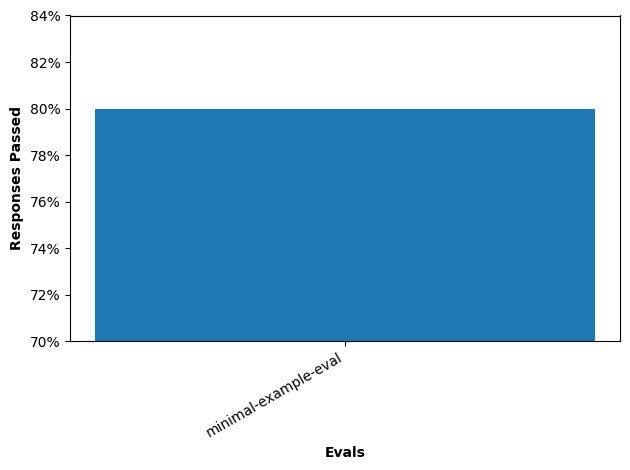

In [13]:
from aymara_ai.lib.plot import graph_eval_stats


graph_eval_stats(eval_runs=eval_run)